In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3

# Sentence-BERT model for embeddings
from sentence_transformers import SentenceTransformer

# K-Means for unsupervised clustering
from sklearn.cluster import KMeans

# For optional sentiment polarity check
from textblob import TextBlob

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Multiprocessing for parallel embedding (optional)
from multiprocessing import Pool, cpu_count

# Install the Hugging Face transformers library
!pip install -q transformers
print(" All required packages are installed and imported successfully!")


 All required packages are installed and imported successfully!


In [2]:
#  Make sure you're on a GPU runtime!
!pip install -q transformers sentence-transformers

**Load Dataset from Database**

In [3]:
import pandas as pd
import sqlite3
from transformers import pipeline
from textblob import TextBlob
import time
from google.colab import drive
from tqdm.auto import tqdm

# Load your data from the database
drive.mount('/content/drive')
db_path = "/content/drive/MyDrive/Colab Notebooks/database/tweetsdatasetM3.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT content_for_sentiment FROM tweetsdatasetM3", conn)
df.dropna(subset=['content_for_sentiment'], inplace=True)
# For your final run, you can use the full df. For testing, a sample is faster.
#Pandas to randomly select 1000 rows from the full DataFrame df
#if first 1000 then
df_sample = df.head(1000)
#df_sample = df.sample(n=1000, random_state=42)
texts = df_sample['content_for_sentiment'].tolist()
# We are now using the full list of texts, not a sample.
#texts = df['content_for_sentiment'].tolist()

print(f"Loaded {len(texts)} tweets from the database for analysis.")

Mounted at /content/drive
Loaded 1000 tweets from the database for analysis.


**Sends each data text in sequnce to an LLM for sentiment classification**




In [4]:
if texts:
    print(f"\n Starting SEQUENTIAL analysis on {len(texts)} tweets (single core)...")
    start_time_seq = time.time()

    # Create a single pipeline for the main process
    sequential_pipeline = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        device=-1 # Ensure it uses CPU
    )

    sequential_results = []
    # Process one by one in a loop
    for text in tqdm(texts, desc="Sequential Processing"):
        result = sequential_pipeline(text, truncation=True)
        sequential_results.append(result[0]['label'].capitalize())

    end_time_seq = time.time()
    sequential_time = end_time_seq - start_time_seq
    print(f" Sequential analysis complete in {sequential_time:.2f} seconds.")

    # CHANGE: Store the results directly into the 'hf_sentiment' column
    df_sample['hf_sentiment'] = sequential_results

    # --- Print first 5 results ---
    # This print statement now works correctly without changes
    print("\n First 5 Sequential Sentiment Results:")
    print(df_sample[['content_for_sentiment', 'hf_sentiment']].head(5))

else:
    print("\nSkipping sequential analysis due to data loading failure.")


 Starting SEQUENTIAL analysis on 1000 tweets (single core)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Sequential Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


 Sequential analysis complete in 180.33 seconds.

 First 5 Sequential Sentiment Results:
                               content_for_sentiment hf_sentiment
0  is history repeating itselfdontnormalizehate h...     Negative
1  barackobama thank you for your incredible grac...     Positive
2                      life goals httpstcoxin1qkmkql      Neutral
3                   me right now  httpstcogw55c1wrwd      Neutral
4  sisters are doin it for themselves  httpstco0s...      Neutral


/tmp/ipython-input-1684437564.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['hf_sentiment'] = sequential_results


**Sends each data text in parallel to an LLM for sentiment classification**




In [5]:
# This function will be run by each parallel process
def process_chunk(text_chunk):
    # Initialize the model inside the worker function for multiprocessing compatibility
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        device=-1  # Use CPU for worker processes
    )
    # The pipeline processes the entire chunk in batches
    results = sentiment_pipeline(list(text_chunk), batch_size=8, truncation=True)
    return [result['label'].capitalize() for result in results]

if texts:
    num_cores = cpu_count()
    text_chunks = np.array_split(texts, num_cores)

    print(f"\n Starting PARALLEL analysis on {len(texts)} tweets using {num_cores} CPU cores...")
    start_time_par = time.time()

    with Pool(num_cores) as pool:
        # Use tqdm to visualize progress
        chunk_results = list(tqdm(pool.imap(process_chunk, text_chunks), total=len(text_chunks), desc="Parallel Processing"))

    end_time_par = time.time()
    parallel_time = end_time_par - start_time_par
    print(f" Parallel analysis complete in {parallel_time:.2f} seconds.")

    # Flatten the list of lists into a single list of results and store it
    parallel_results = [label for chunk in chunk_results for label in chunk]

    # --- Print first 5 results directly from the lists ---
    # We create a temporary DataFrame here just for clean printing, without modifying df_sample
    print("\n First 5 Parallel Sentiment Results (not added to DataFrame):")
    temp_df = pd.DataFrame({
        'content_for_sentiment': texts[:5],
        'hf_sentiment_parallel': parallel_results[:5]
    })
    print(temp_df)

else:
    print("\nSkipping parallel analysis due to data loading failure.")


 Starting PARALLEL analysis on 1000 tweets using 2 CPU cores...


Parallel Processing:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

 Parallel analysis complete in 147.63 seconds.

 First 5 Parallel Sentiment Results (not added to DataFrame):
                               content_for_sentiment hf_sentiment_parallel
0  is history repeating itselfdontnormalizehate h...              Negative
1  barackobama thank you for your incredible grac...              Positive
2                      life goals httpstcoxin1qkmkql               Neutral
3                   me right now  httpstcogw55c1wrwd               Neutral
4  sisters are doin it for themselves  httpstco0s...               Neutral


**FINAL PERFORMANCE**

In [6]:
print("\n--- FINAL PERFORMANCE SUMMARY (CPU) ---")
print(f"Sequential Processing Time (1 Core): {sequential_time:.2f} seconds")
print(f"Parallel Processing Time ({cpu_count()} Cores): {parallel_time:.2f} seconds")

# Calculate the speedup
speedup = sequential_time / parallel_time
print(f"--> Speedup achieved: {speedup:.2f}x faster!")


--- FINAL PERFORMANCE SUMMARY (CPU) ---
Sequential Processing Time (1 Core): 180.33 seconds
Parallel Processing Time (2 Cores): 147.63 seconds
--> Speedup achieved: 1.22x faster!


**ACCURACY SUMMARY USING TRADITIONAL TEXTBLOB**


 Starting traditional analysis with TextBlob...


/tmp/ipython-input-2617156055.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['textblob_sentiment'] = df_sample['content_for_sentiment'].apply(get_textblob_sentiment)


 TextBlob analysis complete.


--- ACCURACY COMPARISON (Hugging Face vs. TextBlob) ---

Agreement Matrix:
hf_sentiment        Negative  Neutral  Positive
textblob_sentiment                             
Negative                  34       52        13
Neutral                   59      429       113
Positive                  20      117       163

Total Disagreements: 374 out of 1000

Examples where the models DISAGREED:
  - Tweet: 'snowiner i have a delicate chemistry too ...'
    - TextBlob said: Negative
    - Hugging Face (LLM) said: Neutral

  - Tweet: 'johnlordperry tears of my doubters...'
    - TextBlob said: Neutral
    - Hugging Face (LLM) said: Negative

  - Tweet: 'peacefully protest...'
    - TextBlob said: Positive
    - Hugging Face (LLM) said: Neutral



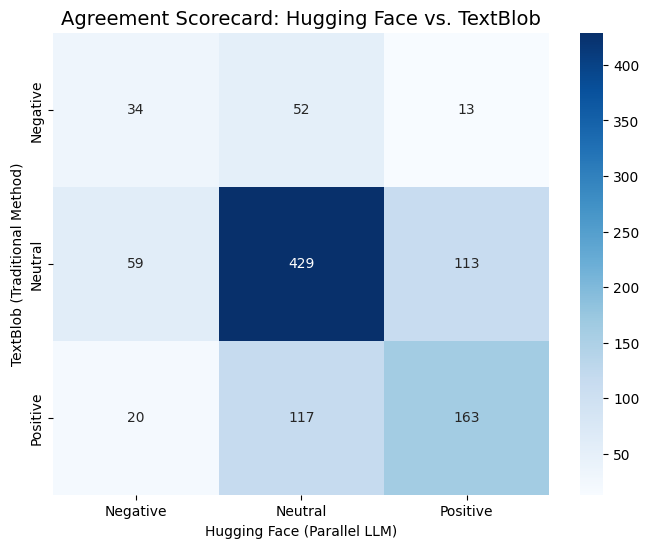

In [7]:
# --- Define the TextBlob function ---
def get_textblob_sentiment(text):
    """Analyzes text polarity and returns 'Positive', 'Negative', or 'Neutral'."""
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"




# --- Apply TextBlob analysis to the df_sample DataFrame ---
print("\n Starting traditional analysis with TextBlob...")
df_sample['textblob_sentiment'] = df_sample['content_for_sentiment'].apply(get_textblob_sentiment)
print(" TextBlob analysis complete.")

# --- ACCURACY COMPARISON ---
print("\n\n--- ACCURACY COMPARISON (Hugging Face vs. TextBlob) ---")

# This will now work because both 'hf_sentiment' and 'textblob_sentiment' exist in df_sample
try:
    # Create the confusion matrix (crosstab)
    comparison_matrix = pd.crosstab(df_sample['textblob_sentiment'], df_sample['hf_sentiment'])
    print("\nAgreement Matrix:")
    print(comparison_matrix)

    # Filter for disagreements
    disagreements = df_sample[df_sample['textblob_sentiment'] != df_sample['hf_sentiment']]
    print(f"\nTotal Disagreements: {len(disagreements)} out of {len(df_sample)}")

    # Display a few random examples of disagreements
    if not disagreements.empty:
        print("\nExamples where the models DISAGREED:")
        for i, row in disagreements.sample(n=3, random_state=42).iterrows():
            print(f"  - Tweet: '{row['content_for_sentiment'][:80]}...'")
            print(f"    - TextBlob said: {row['textblob_sentiment']}")
            print(f"    - Hugging Face (LLM) said: {row['hf_sentiment']}\n")

    # --- VISUALIZATION ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(comparison_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Agreement Scorecard: Hugging Face vs. TextBlob', fontsize=14)
    plt.ylabel('TextBlob (Traditional Method)')
    plt.xlabel('Hugging Face (Parallel LLM)')
    plt.show()

except KeyError as e:
    print(f"\n ERROR: A required column is missing: {e}")
    print("Please ensure you have run the parallel analysis cell to create the 'hf_sentiment_parallel' column before running this comparison.")



--- Final Accurate Sentiment Distribution ---
hf_sentiment
Neutral     598
Positive    289
Negative    113
Name: count, dtype: int64


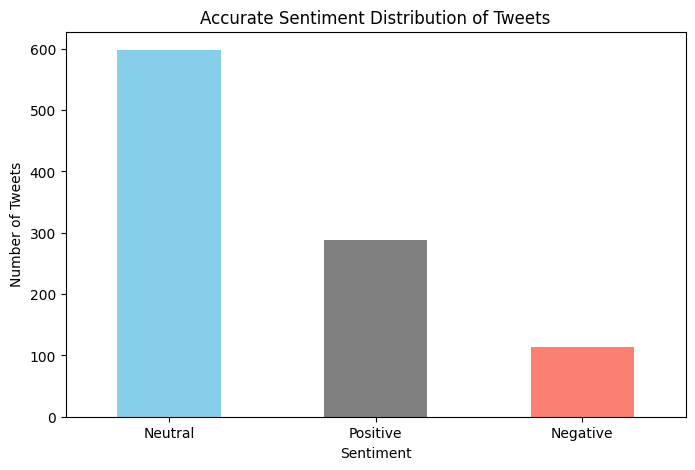

In [8]:
# --- FINAL SENTIMENT SUMMARY (from Hugging Face) ---

# FIX: Use df_sample, which contains the 'hf_sentiment' column.
sentiment_counts = df_sample['hf_sentiment'].value_counts()

print("\n\n--- Final Accurate Sentiment Distribution ---")
print(sentiment_counts)

# This part remains the same as it correctly uses the sentiment_counts variable
sentiment_counts.plot(kind='bar', color=['skyblue', 'gray', 'salmon'], figsize=(8, 5))
plt.title('Accurate Sentiment Distribution of Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()

In [9]:
if texts:
    try:
        print("\n Saving all three sentiment analyses to the database...")
        conn = sqlite3.connect(db_path)
        # Save the final DataFrame to a new table called 'milestone3_results'
        df_sample.to_sql("milestone3_results", conn, if_exists="replace", index=False)

        print(" Success! All results have been saved to the 'milestone3_results' table.")

        # Verify by reading the table back (optional)
        conn = sqlite3.connect(db_path)
        df_verify = pd.read_sql_query("SELECT * FROM milestone3_results LIMIT 5", conn)
        print("\n--- Verification: First 5 rows from the new table ---")
        print(df_verify)

    except Exception as e:
        print(f"An error occurred while saving to the database: {e}")
else:
    print("\nSkipping database save operation as no analysis was performed.")


 Saving all three sentiment analyses to the database...
 Success! All results have been saved to the 'milestone3_results' table.

--- Verification: First 5 rows from the new table ---
                               content_for_sentiment hf_sentiment  \
0  is history repeating itselfdontnormalizehate h...     Negative   
1  barackobama thank you for your incredible grac...     Positive   
2                      life goals httpstcoxin1qkmkql      Neutral   
3                   me right now  httpstcogw55c1wrwd      Neutral   
4  sisters are doin it for themselves  httpstco0s...      Neutral   

  textblob_sentiment  
0            Neutral  
1           Positive  
2            Neutral  
3           Positive  
4            Neutral  


In [10]:
# 3. Define your SQL query as a string
sql_query = "SELECT * FROM milestone3_results LIMIT 10;"

# 4. Use pandas to execute the query and load the results into a DataFrame
df_query_results = pd.read_sql_query(sql_query, conn)
# 6. Display the results
print("Query Results:")
print(df_query_results)

Query Results:
                               content_for_sentiment hf_sentiment  \
0  is history repeating itselfdontnormalizehate h...     Negative   
1  barackobama thank you for your incredible grac...     Positive   
2                      life goals httpstcoxin1qkmkql      Neutral   
3                   me right now  httpstcogw55c1wrwd      Neutral   
4  sisters are doin it for themselves  httpstco0s...      Neutral   
5  happy 96th gma fourmoreyears   lacma los angel...     Positive   
6            kyoto japan \n1 5 17 httpstcoo28m0vw9lr      Neutral   
7                 sanrio puroland httpstcoexvev5umbx      Neutral   
8             2017 resolution to embody authenticity      Neutral   
9                         sisters httpstco5ze21x2ank      Neutral   

  textblob_sentiment  
0            Neutral  
1           Positive  
2            Neutral  
3           Positive  
4            Neutral  
5           Positive  
6            Neutral  
7            Neutral  
8            Neutr

In [11]:
import pandas as pd
import sqlite3
from google.colab import drive

# --- 1. Mount Google Drive and connect to the database ---
drive.mount('/content/drive', force_remount=True)
db_path = "/content/drive/MyDrive/Colab Notebooks/database/tweetsdatasetM3.db"
conn = sqlite3.connect(db_path)

# --- 2. Load the final results table into a DataFrame ---
# This reads the table you created in the previous step.
print("Reading the 'milestone3_results' table from the database...")
df_results = pd.read_sql_query("SELECT * FROM milestone3_results", conn)
conn.close()
print("Table loaded successfully.")

# --- 3. Convert the DataFrame to a CSV file ---
output_filename = 'sentiment_analysis_results.csv'
df_results.to_csv(output_filename, index=False)

print(f"\n Success! The table has been converted and saved as '{output_filename}'.")
print("You can find the file in the Colab file browser on the left.")

Mounted at /content/drive
Reading the 'milestone3_results' table from the database...
Table loaded successfully.

 Success! The table has been converted and saved as 'sentiment_analysis_results.csv'.
You can find the file in the Colab file browser on the left.


In [12]:
import pandas as pd
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication

# --- 1. Prepare the Data and CSV File ---
# Assuming 'df_sample' is your DataFrame with the sentiment results.
# If you used a different name, change 'df_sample' to your DataFrame's name.
csv_filename = "sentiment_analysis_results.csv"
df_sample.to_csv(csv_filename, index=False)
print(f"'{csv_filename}' created successfully.")

# --- 2. Construct the Email ---
# Use MIMEMultipart to handle both text and attachments
msg = MIMEMultipart()

# Set the subject, sender, and recipient
msg['Subject'] = "Sentiment Analysis Report - Milestone 3 Results"
msg['From'] = "websitehosting0123@gmail.com"
msg['To'] = "mobilepersonaluse5@gmail.com"

# Create the body/description of the email
body = """
Hello,

Please find the attached CSV file containing the detailed sentiment analysis results.

This report includes sentiment classifications from:
- Hugging Face (Parallel LLM)

- TextBlob Traditional Method

Best regards,
Automated Analysis Script
"""
msg.attach(MIMEText(body, 'plain'))

# --- 3. Attach the CSV File ---
try:
    with open(csv_filename, "rb") as attachment:
        # Create a MIMEApplication object for the attachment
        part = MIMEApplication(
            attachment.read(),
            Name=csv_filename
        )
    # Add the necessary header to define it as an attachment
    part['Content-Disposition'] = f'attachment; filename="{csv_filename}"'
    msg.attach(part)
    print("CSV file attached to the email.")

except FileNotFoundError:
    print(f"Error: The file '{csv_filename}' was not found. Please ensure it was created correctly.")
    # Stop if the file doesn't exist
    exit()

# --- 4. Send the Email ---
try:
    # Use your Gmail app password here for security
    app_password = "tzfheimxphcssuag"  # IMPORTANT: PASTE YOUR 16-DIGIT GMAIL APP PASSWORD HERE

    if not app_password:
        raise ValueError("App password is not set. Please add it to the 'app_password' variable.")

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
        server.login("websitehosting0123@gmail.com", app_password)
        server.sendmail(msg['From'], [msg['To']], msg.as_string())

    print("\n Success! The email with the CSV attachment has been sent.")

except smtplib.SMTPAuthenticationError:
    print("\n Authentication failed. Please check your email address and ensure you are using a valid 16-digit App Password.")
except Exception as e:
    print(f"\n An error occurred while sending the email: {e}")

'sentiment_analysis_results.csv' created successfully.
CSV file attached to the email.

 Success! The email with the CSV attachment has been sent.
